In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import numpy as np
import pybeads
import joblib
from scipy import fftpack
import copy
import sys


In [2]:
sys.path.append("FlowMater")
sys.path.append("IonLib/")

from dataframe_parse import add_unique_IDs

In [3]:
#data load
df_path="temp/df.bin"
df=joblib.load(df_path)
fp_keys=joblib.load("temp/all_fp_keys.bin")
anal_df=add_unique_IDs(df,fp_keys)

IonLib/dataframe_parse.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anal_df["Anneal"][anal_df["Anneal"] >= 1] = 1


In [4]:
#denoise by fft
def remove_noise(target_df,cutoff=0.002,N=10,target_y="y"):
    y=np.array(target_df[target_y])
    sample_freq =fftpack.fftfreq(df.shape[0],d=10)
    sig_fft=fftpack.fft(y)
    sig_fft[np.abs(sample_freq) >cutoff] = 0  
    main_sig =np.real( fftpack.ifft(sig_fft)) 

    new_df=copy.deepcopy(target_df)
    new_df[target_y]=main_sig
    
    return new_df[N:-N]


#plt.plot(denoise_df["y"])


In [5]:
def beads(denoise_df,fc = 0.02 ):
    #constantなbackground成分を削除
    y=np.array(denoise_df.y)-min(denoise_df.y)


    #解析アルゴリズムは、両端が0じゃないとだめなので、人工的に両端をゼロにする

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    xscale_l, xscale_r = 300, 100
    dx = 1
    y_difficult=y
    y_difficult_l = y_difficult[0]*sigmoid(1/xscale_l*np.arange(-5*xscale_l, 5*xscale_l, dx))
    y_difficult_r = y_difficult[-1]*sigmoid(-1/xscale_r*np.arange(-5*xscale_r, 5*xscale_r, dx))
    y_difficult_ext = np.hstack([y_difficult_l, y_difficult, y_difficult_r])
    len_l, len_o, len_r = len(y_difficult_l), len(y_difficult), len(y_difficult_r)

    #plt.plot(range(len_l, len_l+len_o), y_difficult)
    #plt.plot(y_difficult_l, 'C1')
    #plt.plot(range(len_l+len_o, len_l+len_o+len_r), y_difficult_r, 'C1')

    #fc = 0.006 # ハイパスフィルター作成に使うcutoff周波数
    #fc = 0.02 # 5,20,0
    #fc = 0.008 # 10

    d = 1 # ハイパスフィルター作成時のパラメータ。1でよい。詳細は論文参照。
    r = 6 # 非対称ペナルティの非対称具合

    # 測定データとその微分にかかる正規化パラメータ
    amp = 0.8
    lam0 = 0.5 * amp
    lam1 = 5 * amp
    lam2 = 4 * amp
    # MMアルゴリズムのループ回数
    Nit = 15
    # ペナルティー関数
    pen = 'L1_v2'

    y_est, bg_est, cost = pybeads.beads(y_difficult_ext, d, fc, r, Nit, lam0, lam1, lam2, pen, conv=None)

    plt.figure()
    fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)
    fig.subplots_adjust(hspace=0)
    fig.patch.set_color('white')
    axes[0].plot(y_difficult_ext, c='k', label='original data')
    axes[0].plot(bg_est, c='r', label='BG estimated by BEADS')
    axes[0].legend()

    axes[1].plot(y_est, label='y estimated by BEADS')
    axes[1].legend()
    axes[2].plot(y_est-y_est-bg_est, label='noise estimated by BEADS')
    axes[2].legend()

    #prepare dataframe
    start_pos=y_difficult_l.shape[0]
    end_pos=y_difficult_r.shape[0]
    fit_df=pd.DataFrame()
    fit_df["x"]=denoise_df.x
    fit_df["y"]=y_est[start_pos:-end_pos]
    fit_df["bg"]=bg_est[start_pos:-end_pos]

    return fit_df

def get_peak_area(fit_df):
    cryst_area=np.sum(fit_df["y"])
    amor_area=np.sum(fit_df["bg"])
    return cryst_area,amor_area
    #return (cryst_area/(cryst_area+amor_area)*100)

In [6]:
def auto_load(data_path):
    with open(data_path,"r", errors='ignore',encoding="UTF-8-sig") as f:
        txt=f.read()

    txt_lines=txt.split("\n")

    #find end of header
    for header_pos in range(len(txt_lines)):
        if txt_lines[header_pos].find("Offset	0")>=0:
            break
        if txt_lines[header_pos].find("Theta	0")>=0:
            break       
    header_pos+=1

    #set main data lines
    main_lines=txt_lines[header_pos:]

    #data=[i.split("\t") for i in main_lines]
    data=[]
    for i in main_lines:
        temp=i.split("\t")
        
        if len(temp)<2:
            break
        if i[0]==".":
            break
        data.append(temp)
    
    data_array=np.array(data[:-1]).astype(float)

    df=pd.DataFrame(data_array).astype(float)
    df.columns=["x","y"]
    
    return df

In [7]:
processed_df=copy.deepcopy(df)

#load xrd data
xrd_dict={}
xrd_label="XRD_load_data"
for i in range(processed_df.shape[0]):
    if not processed_df[xrd_label][i]==processed_df[xrd_label][i]:
        continue
    data_path=processed_df[xrd_label][i]
    ind=processed_df.index[i]
    
    xrd_dict[ind]=auto_load(data_path)

normal_experiment181_database/experiments/MU/xrd/1102/intensive/1029/xrd.graphml
normal_experiment182_database/experiments/MU/xrd/1102/intensive/1101/xrd.graphml
normal_experiment183_database/experiments/MU/xrd/1102/intensive/liftfsi/xrd.graphml
normal_experiment184_graph_integrated_json_0_database/experiments/MU/xrd/1102/parallel/1018/xrd.graphml
normal_experiment184_graph_integrated_json_1_database/experiments/MU/xrd/1102/parallel/1018/xrd.graphml
normal_experiment184_graph_integrated_json_2_database/experiments/MU/xrd/1102/parallel/1018/xrd.graphml
normal_experiment184_graph_integrated_json_3_database/experiments/MU/xrd/1102/parallel/1018/xrd.graphml
normal_experiment185_graph_integrated_json_0_database/experiments/MU/xrd/1102/parallel/1029/xrd.graphml
normal_experiment185_graph_integrated_json_1_database/experiments/MU/xrd/1102/parallel/1029/xrd.graphml
normal_experiment185_graph_integrated_json_2_database/experiments/MU/xrd/1102/parallel/1029/xrd.graphml
normal_experiment185_graph

/home/user/anaconda3/envs/mi/lib/python3.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


normal_experiment186_graph_integrated_json_0_database/experiments/MU/xrd/1102/parallel/1101/xrd.graphml
normal_experiment186_graph_integrated_json_1_database/experiments/MU/xrd/1102/parallel/1101/xrd.graphml
normal_experiment186_graph_integrated_json_2_database/experiments/MU/xrd/1102/parallel/1101/xrd.graphml
normal_experiment186_graph_integrated_json_3_database/experiments/MU/xrd/1102/parallel/1101/xrd.graphml
normal_experiment186_graph_integrated_json_4_database/experiments/MU/xrd/1102/parallel/1101/xrd.graphml
normal_experiment187_graph_integrated_json_0_database/experiments/MU/xrd/1102/parallel/liftfsi/xrd.graphml
normal_experiment187_graph_integrated_json_1_database/experiments/MU/xrd/1102/parallel/liftfsi/xrd.graphml
normal_experiment187_graph_integrated_json_2_database/experiments/MU/xrd/1102/parallel/liftfsi/xrd.graphml
normal_experiment187_graph_integrated_json_3_database/experiments/MU/xrd/1102/parallel/liftfsi/xrd.graphml
normal_experiment188_database/experiments/MU/xrd/903

<Figure size 432x288 with 0 Axes>

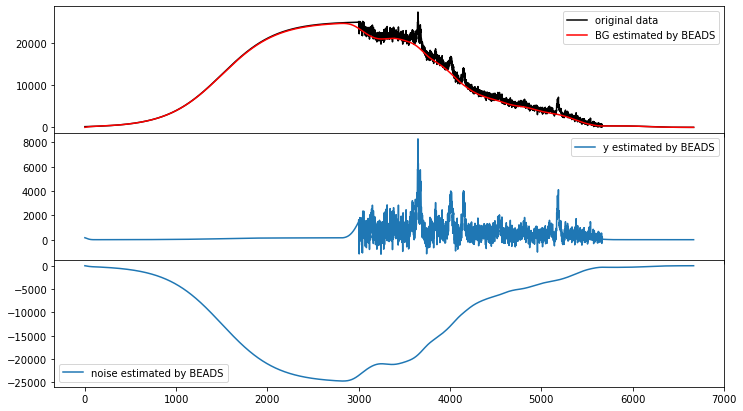

<Figure size 432x288 with 0 Axes>

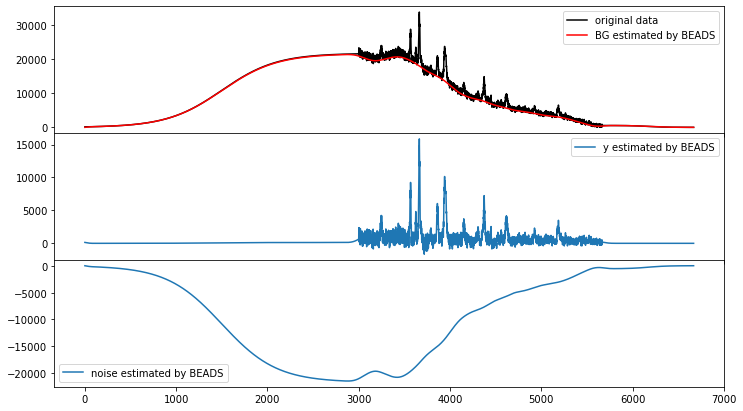

<Figure size 432x288 with 0 Axes>

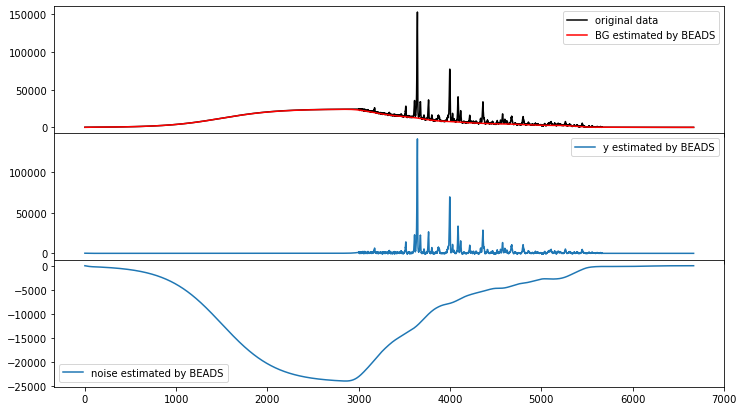

<Figure size 432x288 with 0 Axes>

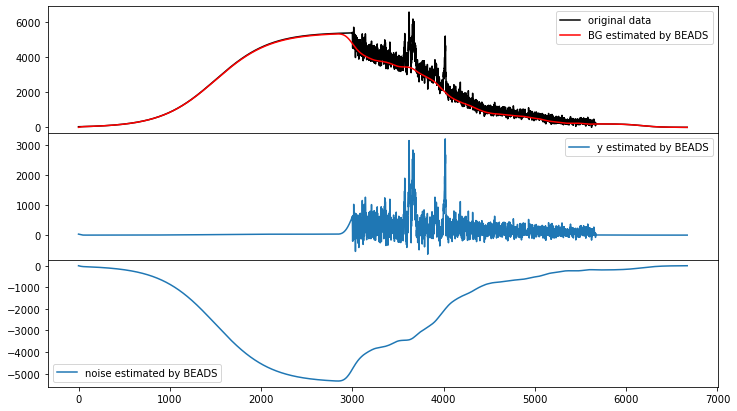

<Figure size 432x288 with 0 Axes>

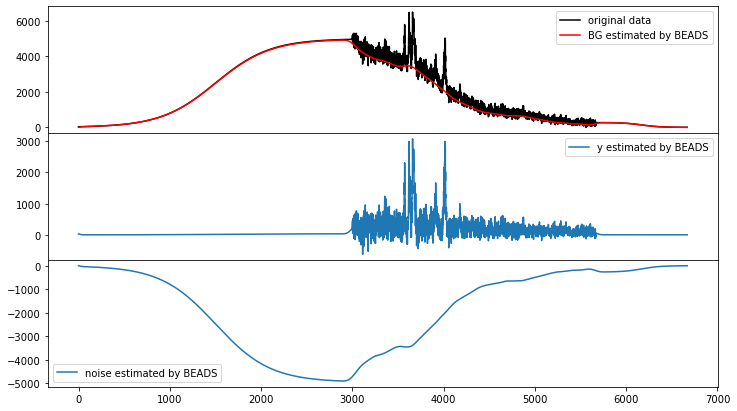

<Figure size 432x288 with 0 Axes>

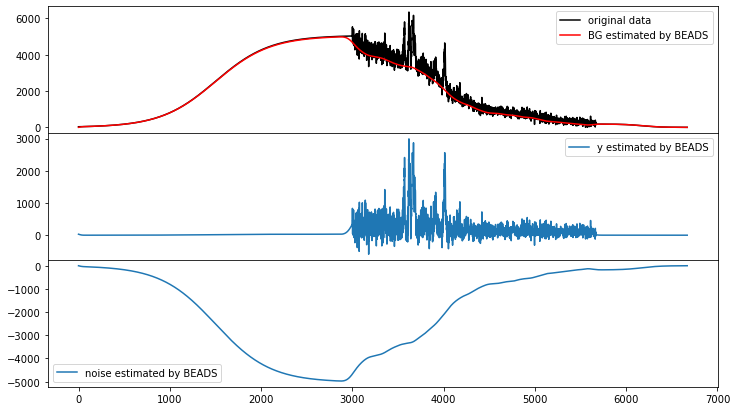

<Figure size 432x288 with 0 Axes>

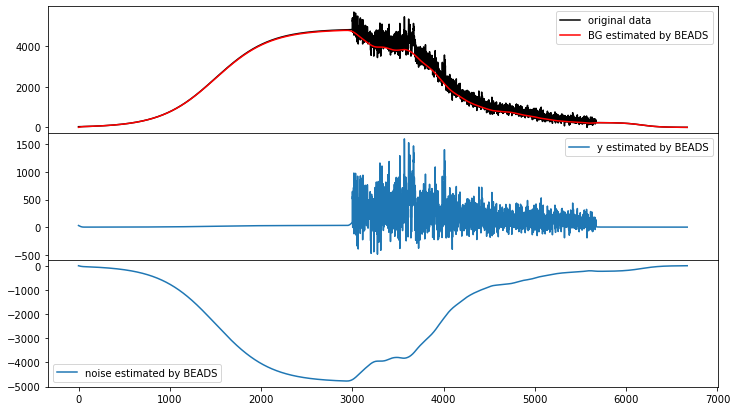

<Figure size 432x288 with 0 Axes>

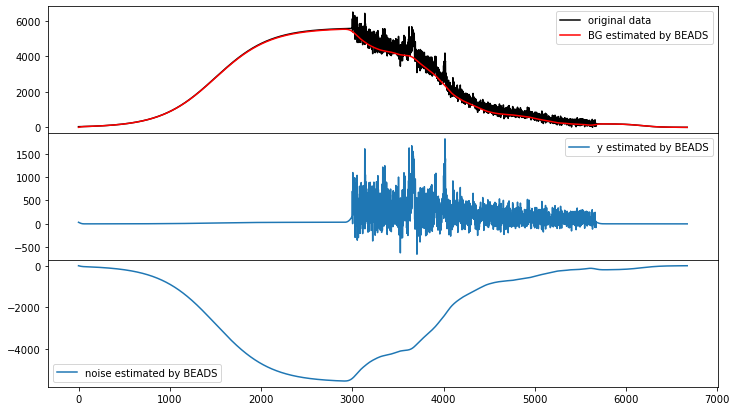

<Figure size 432x288 with 0 Axes>

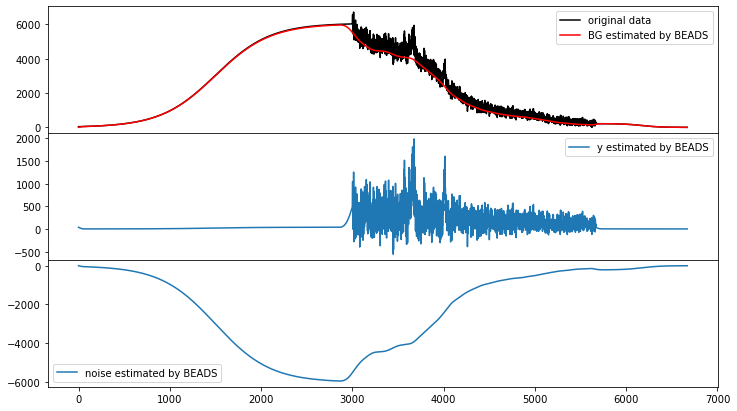

<Figure size 432x288 with 0 Axes>

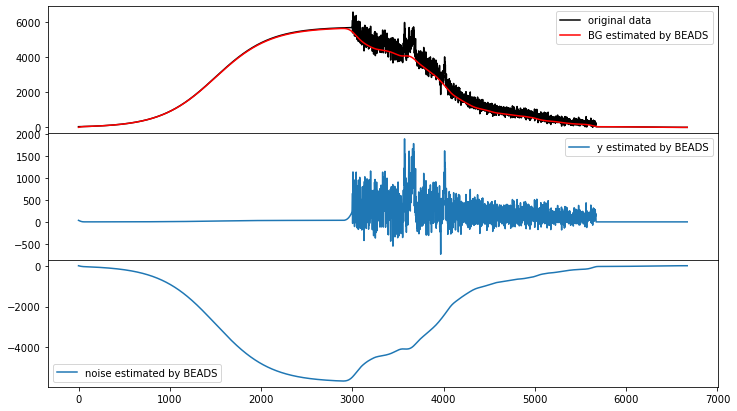

<Figure size 432x288 with 0 Axes>

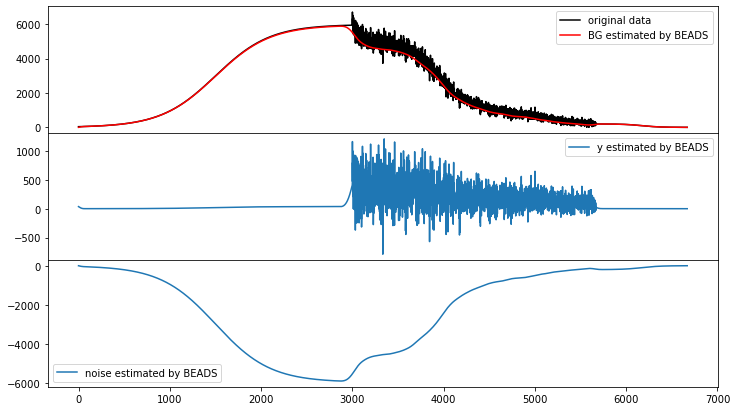

<Figure size 432x288 with 0 Axes>

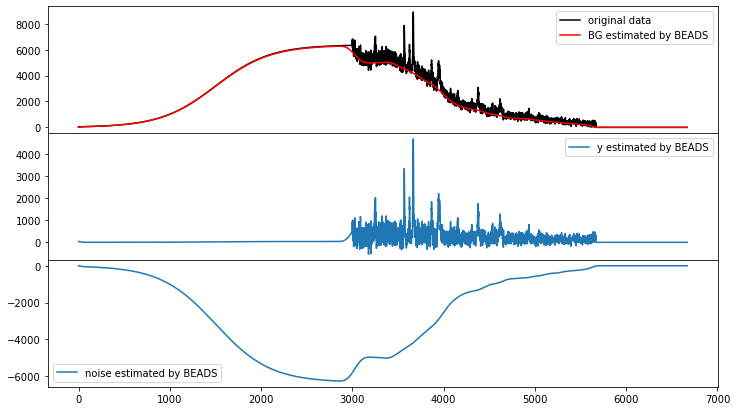

<Figure size 432x288 with 0 Axes>

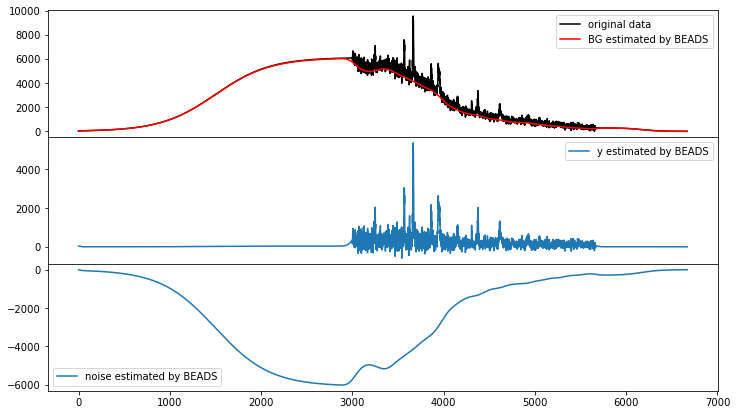

<Figure size 432x288 with 0 Axes>

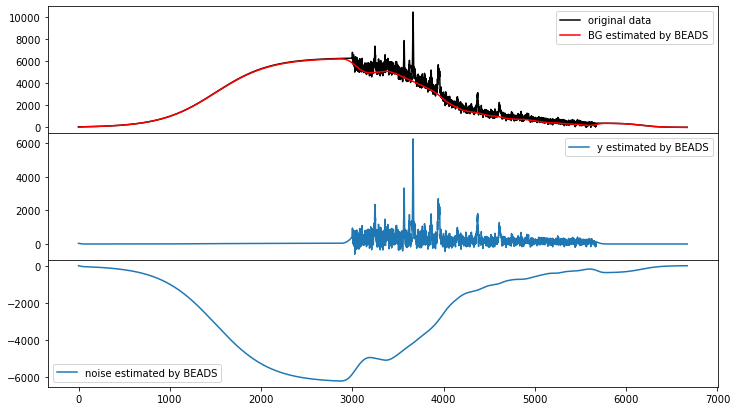

<Figure size 432x288 with 0 Axes>

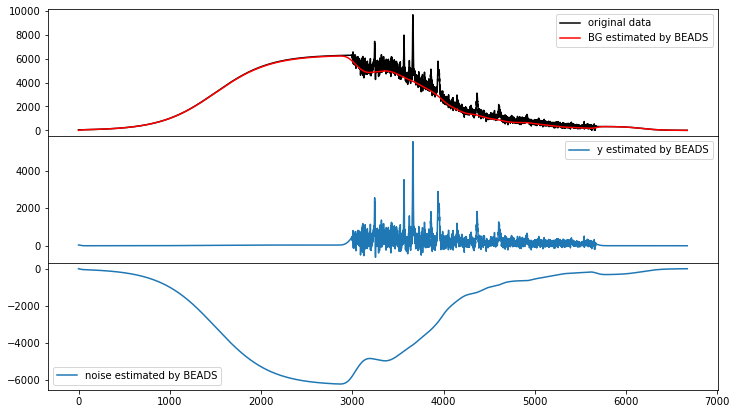

<Figure size 432x288 with 0 Axes>

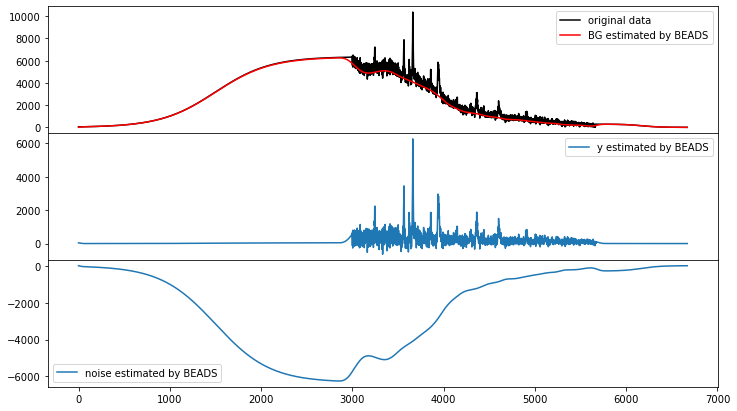

<Figure size 432x288 with 0 Axes>

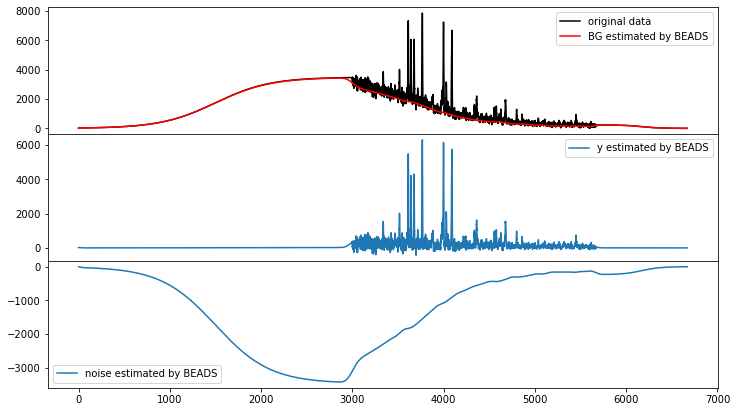

<Figure size 432x288 with 0 Axes>

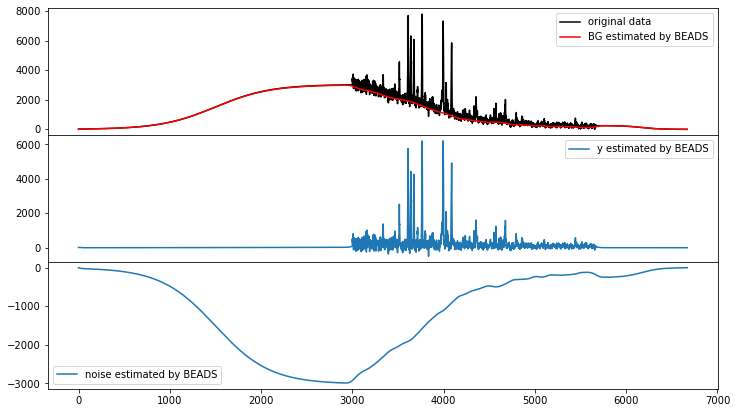

<Figure size 432x288 with 0 Axes>

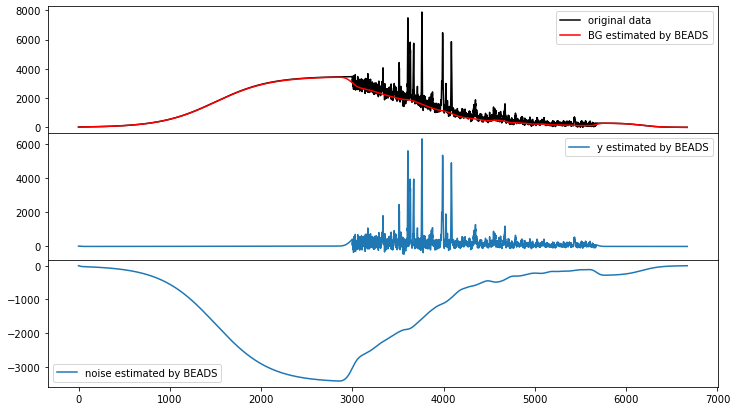

<Figure size 432x288 with 0 Axes>

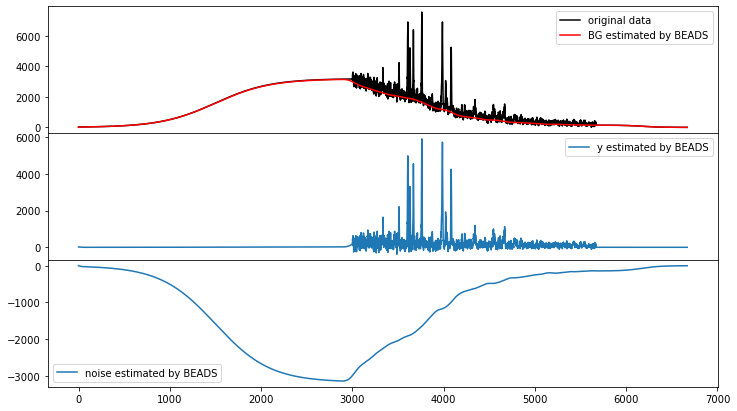

<Figure size 432x288 with 0 Axes>

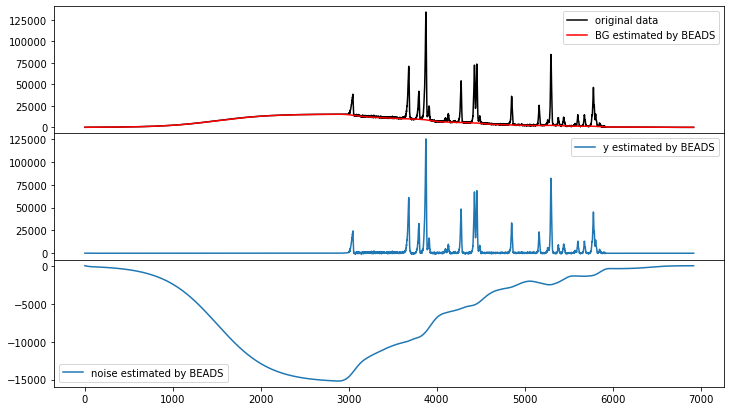

<Figure size 432x288 with 0 Axes>

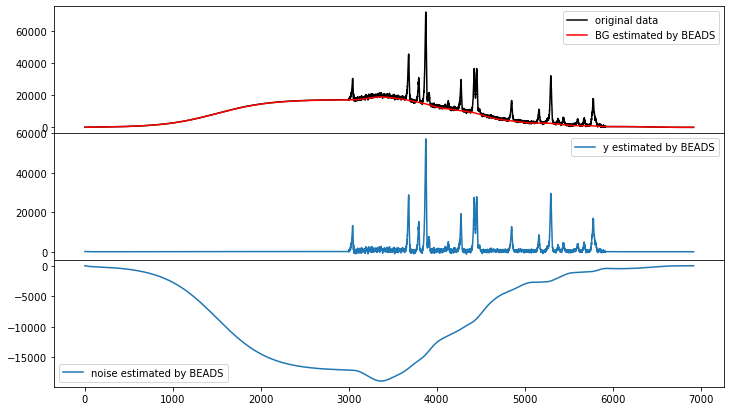

<Figure size 432x288 with 0 Axes>

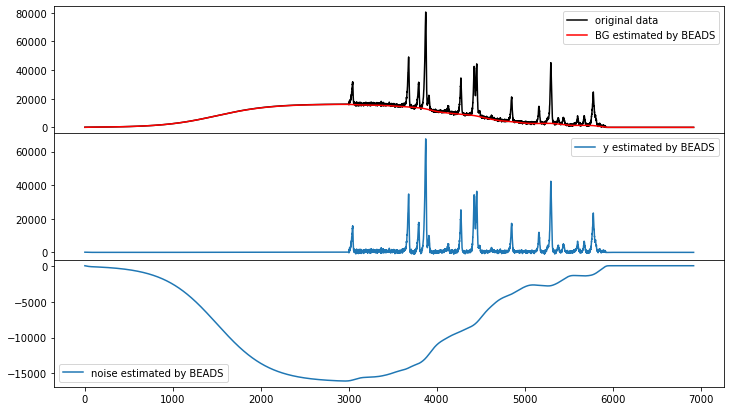

<Figure size 432x288 with 0 Axes>

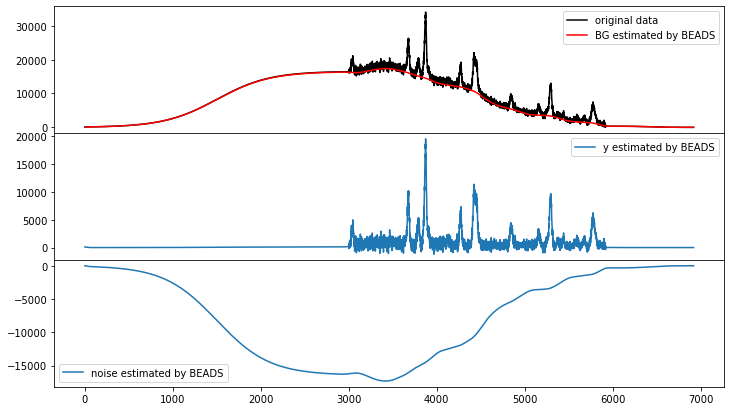

<Figure size 432x288 with 0 Axes>

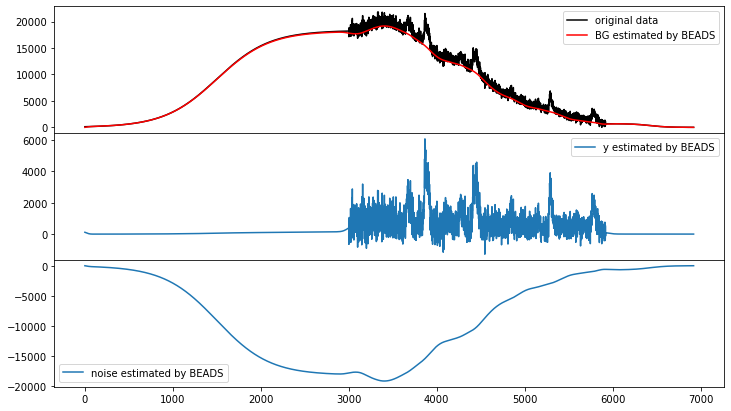

<Figure size 432x288 with 0 Axes>

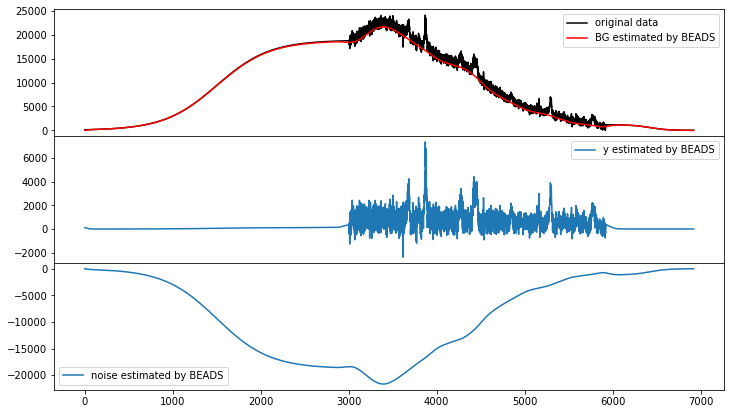

<Figure size 432x288 with 0 Axes>

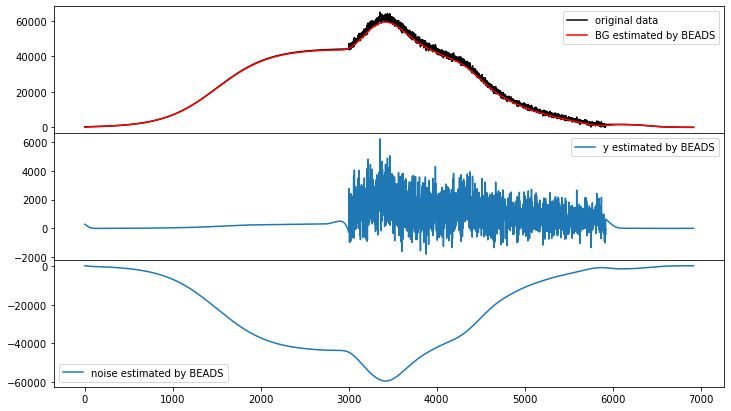

In [8]:

parsed_dict={}
ratio_dict={}
cryst_area_dict={}
amor_area_dict={}


for key in xrd_dict:
    df=xrd_dict[key]
    df=df[:3000]

    print(key)
    denoise_df=remove_noise(df,target_y="y",cutoff=1,N=40)
    
    parsed_dict[key]=beads(denoise_df,fc=0.015)
    
    cryst_area,amor_area=get_peak_area(parsed_dict[key])
    ratio_dict[key]=(cryst_area/(cryst_area+amor_area)*100)
    cryst_area_dict[key]=cryst_area
    amor_area_dict[key]=amor_area
    


In [9]:
"""
ratio_dict
cryst_area_dict
amor_area_dict

pd.DataFrame.from_dict(ratio_dict)"""

'\nratio_dict\ncryst_area_dict\namor_area_dict\n\npd.DataFrame.from_dict(ratio_dict)'

In [10]:
sel_df=anal_df[anal_df[xrd_label]==anal_df[xrd_label]]
sel_df["XRD condition"]=sel_df["manual condition"]+"-"+sel_df["XRD_temperature"].str.replace(" oC","")\
+sel_df["XRD_method"].str.replace("intensive beam","I").str.replace("parallel beam","P")
sel_df["XRD condition"]=sel_df["XRD condition"].str.replace("nan","")

all_electrolyte_list=list(sel_df["XRD condition"])
all_electrolyte_dict={k:v for k,v in zip(all_electrolyte_list,sel_df.index)}
sorted(list(all_electrolyte_dict))

/home/user/anaconda3/envs/mi/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/user/anaconda3/envs/mi/lib/python3.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


['D100LG-25I',
 'M100LG-100P',
 'M100LG-25I',
 'M100LG-25P',
 'M100LG-50P',
 'M100LG-80P',
 'OL80-100LG-25I',
 'OLD60-50LG-25I',
 'OLD79-10LG-25I',
 'OLD79-7LG-25I',
 'OLD80-20LG-25I',
 'OLD80-24LG-100P',
 'OLD80-24LG-120P',
 'OLD80-24LG-25I',
 'OLD80-24LG-25P',
 'OLD80-24LG-50P',
 'OLD80-24LG-80P',
 'OLD80-30LG-25I',
 'OLM60-20LG-100P',
 'OLM60-20LG-25I',
 'OLM60-20LG-25P',
 'OLM60-20LG-50P',
 'OLM60-20LG-80P',
 'OLM60-31LG-100P',
 'OLM60-31LG-25P',
 'OLM60-31LG-50P',
 'OLM60-31LG-80P']

# visualize

In [11]:


plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams["font.size"] = 16

def auto_xrd_plot(olm_temp_electrolytes,offset=3500,x_range=(10,50)):

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, 
                                   sharex=True,
                                   figsize=(8,len(olm_temp_electrolytes)),dpi=100)
    #fig = plt.figure(figsize=(8,4),dpi=100)

    
    for ax,current_dict in zip((ax1,ax2),[xrd_dict,parsed_dict]):

        for i,electrolyte in enumerate(olm_temp_electrolytes):
            df=current_dict[all_electrolyte_dict[electrolyte]]
            df=copy.copy(df)
            y=df.y-i*offset
            
            label=electrolyte.replace("LG","")
            label=label.replace("D100","LiTFSI")
            label=label.replace("M100","LiFTFSI")
            label=label.replace("N100","LiFSI")
            label=label.replace("B100","LiBF$_{4}$")
        
            ax.plot(df.x,y,alpha=1,linewidth=1,label=label)
            #sns.lineplot(data=df,x="x",y="y",ax=ax)
            ax.set_ylabel("")
            ax.axes.yaxis.set_ticks([])


    plt.xlim(x_range[0],x_range[1])
    plt.subplots_adjust(wspace=0.4, hspace=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
    plt.xlabel("2$\\theta$ $(^\mathrm{o}$)")
    plt.tick_params(width = 1, length = 10)


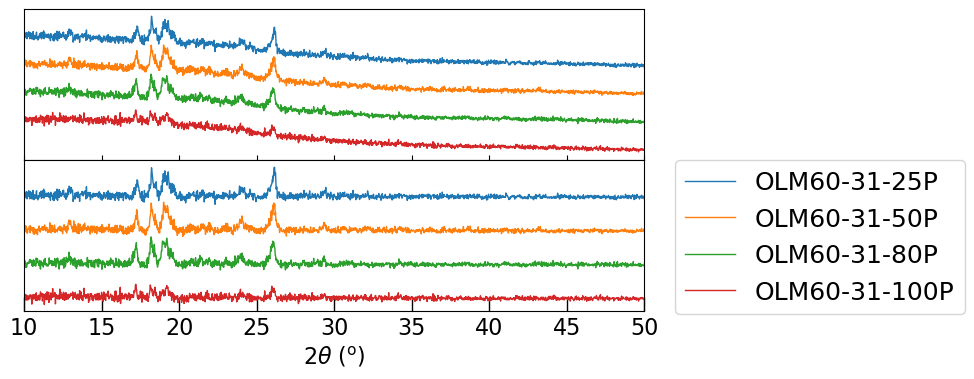

In [12]:
olm_temp_electrolytes=[
 'OLM60-31LG-25P',
 'OLM60-31LG-50P',
 'OLM60-31LG-80P',
 'OLM60-31LG-100P',
]

auto_xrd_plot(olm_temp_electrolytes,offset=3500)

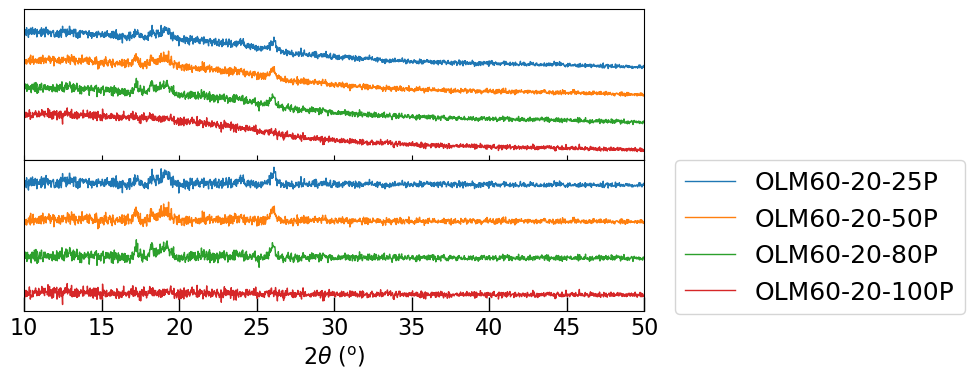

In [13]:
olm54_temp_electrolytes=[
 'OLM60-20LG-25P',
 'OLM60-20LG-50P',
 'OLM60-20LG-80P',
 'OLM60-20LG-100P',
]

auto_xrd_plot(olm54_temp_electrolytes,offset=3500)


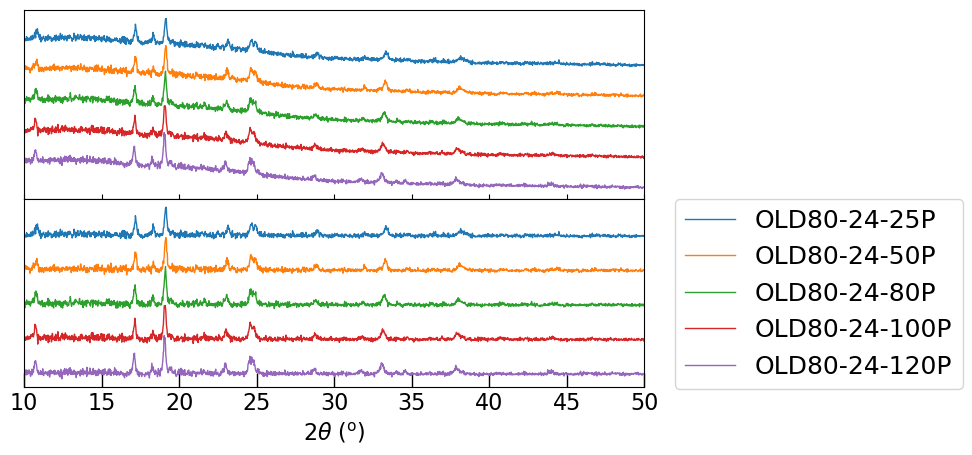

In [14]:
old73_temp_electrolytes=[
 'OLD80-24LG-25P',
 'OLD80-24LG-50P',
 'OLD80-24LG-80P',
 'OLD80-24LG-100P',
 'OLD80-24LG-120P',
]
auto_xrd_plot(old73_temp_electrolytes,offset=5500)


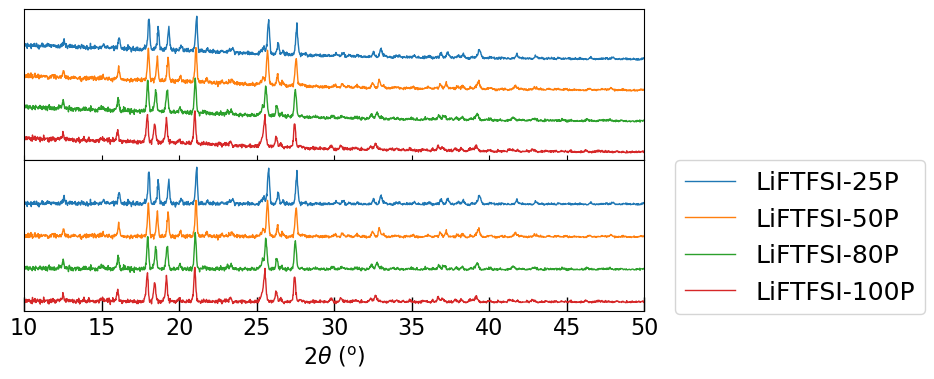

In [15]:
M100_temp_electrolytes=[
 'M100LG-25P',
 'M100LG-50P',
 'M100LG-80P',
'M100LG-100P',
    
]
auto_xrd_plot(M100_temp_electrolytes,offset=5500)


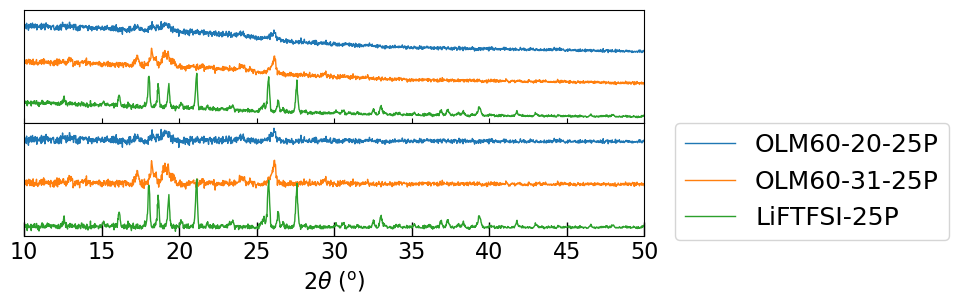

In [16]:
comparison_temp_electrolytes=[
 'OLM60-20LG-25P',
 'OLM60-31LG-25P',
 'M100LG-25P',
]
auto_xrd_plot(comparison_temp_electrolytes,offset=5500)


In [17]:
set(all_electrolyte_list)-set(olm_temp_electrolytes)-set(olm54_temp_electrolytes)-set(old73_temp_electrolytes)-set(M100_temp_electrolytes)

{'D100LG-25I',
 'M100LG-25I',
 'OL80-100LG-25I',
 'OLD60-50LG-25I',
 'OLD79-10LG-25I',
 'OLD79-7LG-25I',
 'OLD80-20LG-25I',
 'OLD80-24LG-25I',
 'OLD80-30LG-25I',
 'OLM60-20LG-25I'}

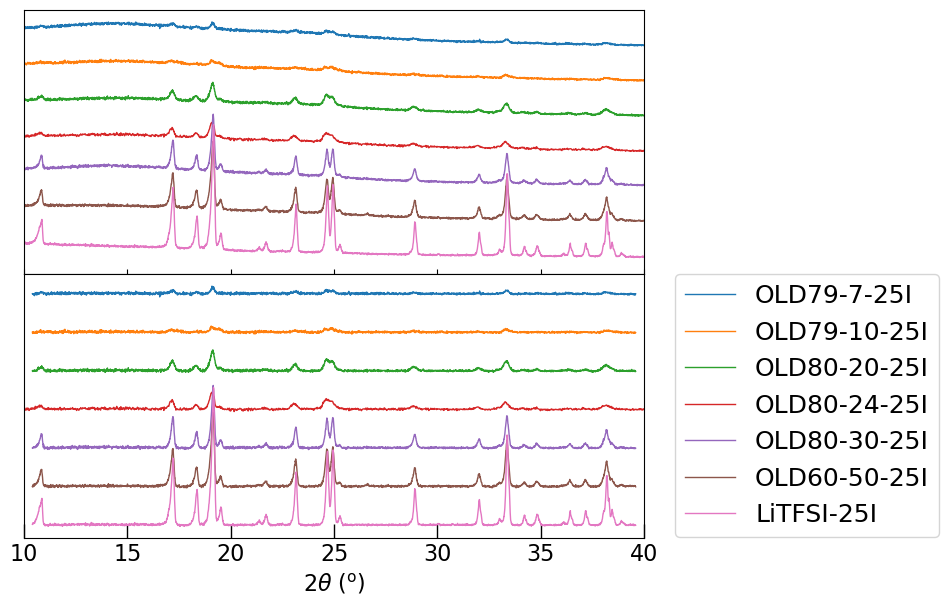

In [18]:
old_electrolytes=[    
 'OLD79-7LG-25I',
 'OLD79-10LG-25I',
 'OLD80-20LG-25I',
 'OLD80-24LG-25I',
 'OLD80-30LG-25I',
 #'OLM60-20LG-25I',
 'OLD60-50LG-25I',
 'D100LG-25I',
    
]
auto_xrd_plot(old_electrolytes,offset=35000,x_range=(10,40))

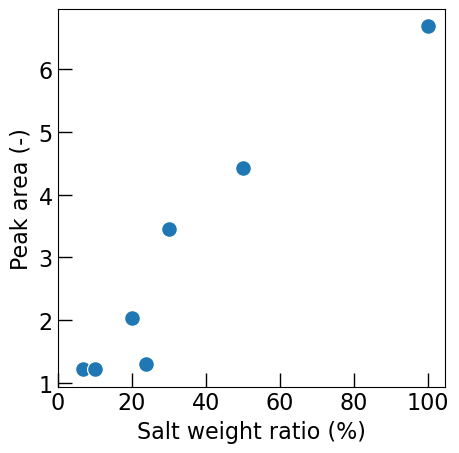

In [19]:
#cryst_area_dict
plt.figure(figsize=(5,5),dpi=100)
area_list=[cryst_area_dict[all_electrolyte_dict[i]] for i in old_electrolytes]
area_list=np.array(area_list)/2/10**6
wt_list=[int(i.split("-")[1][0:-2]) for i in old_electrolytes]
wt_list[-1]=100

area_df=pd.DataFrame([wt_list,area_list]).T
area_df.columns=["Salt weight ratio (%)","Peak area (-)"]
sns.scatterplot(data=area_df,x="Salt weight ratio (%)",y="Peak area (-)",s=130)
#plt.plot([0,wt_list[-1]],[0,area_list[-1]])
plt.xticks(np.arange(0, 101, step=20))
plt.tick_params(width = 1, length = 10)


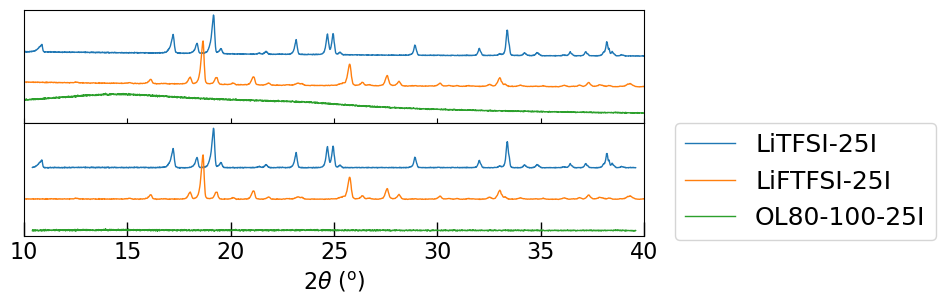

In [20]:
salt_electrolytes=[
'D100LG-25I', 'M100LG-25I',
'OL80-100LG-25I',# 'OLM54-20LG-25I'
    
]
auto_xrd_plot(salt_electrolytes,offset=100000,x_range=(10,40))



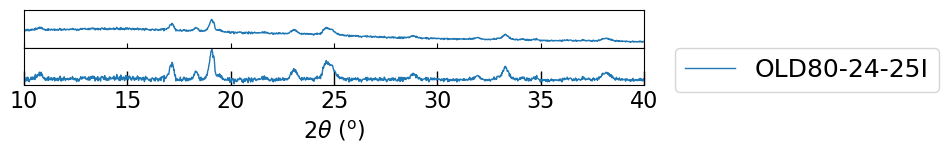

In [21]:
salt_electrolytes=[
 'OLD80-24LG-25I',
    
]
auto_xrd_plot(salt_electrolytes,offset=100000,x_range=(10,40))


In [22]:
set(all_electrolyte_list)-set(olm_temp_electrolytes)-set(olm54_temp_electrolytes)-set(old73_temp_electrolytes)-set(M100_temp_electrolytes)-set(old_electrolytes)-set(salt_electrolytes)

{'M100LG-25I', 'OL80-100LG-25I', 'OLM60-20LG-25I'}